# Task 3: NLP with spaCy - Amazon Product Reviews Analysis

This notebook implements Named Entity Recognition (NER) and sentiment analysis on Amazon product reviews using spaCy.

## Objectives:
1. Download Amazon product reviews dataset using Kaggle API
2. Perform Named Entity Recognition (NER) to extract product names and brands
3. Analyze sentiment using a rule-based approach
4. Display extracted entities and sentiment analysis results

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import kagglehub
import os
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"spaCy version: {spacy.__version__}")
print(f"pandas version: {pd.__version__}")

Libraries imported successfully!
spaCy version: 3.8.7
pandas version: 2.3.2


C:\Users\KOBILO\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Download Amazon Reviews Dataset

We'll use the Kaggle API to download the Amazon reviews dataset from the bittlingmayer/amazonreviews collection.

In [2]:
# Download the Amazon reviews dataset using kagglehub
print("Downloading Amazon reviews dataset...")

try:
    # Download latest version
    path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
    print("Path to dataset files:", path)
    
    # List files in the dataset directory
    import os
    files = os.listdir(path)
    print("\nFiles in the dataset:")
    for file in files:
        file_path = os.path.join(path, file)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
        print(f"  - {file} ({file_size:.1f} MB)")
        
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("You might need to set up Kaggle API credentials first.")
    print("Please check: https://github.com/Kaggle/kaggle-api#api-credentials")

100%|██████████| 493M/493M [38:11<00:00, 226kB/s]   

Extracting files...


Path to dataset files: C:\Users\KOBILO\.cache\kagglehub\datasets\bittlingmayer\amazonreviews\versions\7

Files in the dataset:
  - test.ft.txt.bz2 (50.2 MB)
  - train.ft.txt.bz2 (442.8 MB)


## Step 2: Load and Explore the Dataset

The dataset contains compressed text files. We'll load them and examine the structure of the Amazon reviews data.

In [3]:
import bz2

# Load the test dataset (smaller file for faster processing)
test_file_path = os.path.join(path, 'test.ft.txt.bz2')

# Read compressed file and parse the data
reviews = []
labels = []

print("Loading and parsing the test dataset...")
with bz2.open(test_file_path, 'rt', encoding='utf-8') as file:
    for i, line in enumerate(file):
        if i >= 5000:  # Limit to first 5000 reviews for demonstration
            break
        
        line = line.strip()
        if line:
            # FastText format: __label__1 or __label__2 followed by text
            if line.startswith('__label__1'):
                labels.append('negative')
                review_text = line.replace('__label__1 ', '', 1)
            elif line.startswith('__label__2'):
                labels.append('positive')
                review_text = line.replace('__label__2 ', '', 1)
            else:
                continue
            
            reviews.append(review_text)

# Create DataFrame
df = pd.DataFrame({
    'review_text': reviews,
    'sentiment_label': labels
})

print(f"Loaded {len(df)} reviews")
print(f"Dataset shape: {df.shape}")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nFirst few reviews:")
print(df.head())

Loading and parsing the test dataset...
Loaded 5000 reviews
Dataset shape: (5000, 2)

Sentiment distribution:
sentiment_label
positive    2565
negative    2435
Name: count, dtype: int64

First few reviews:
                                         review_text sentiment_label
0  Great CD: My lovely Pat has one of the GREAT v...        positive
1  One of the best game music soundtracks - for a...        positive
2  Batteries died within a year ...: I bought thi...        negative
3  works fine, but Maha Energy is better: Check o...        positive
4  Great for the non-audiophile: Reviewed quite a...        positive


## Step 3: Setup spaCy NLP Pipeline

We'll load the English language model and configure it for Named Entity Recognition to extract product names and brands.

In [4]:
# Try to load spaCy model, download if necessary
try:
    # Try to load the English model
    nlp = spacy.load("en_core_web_sm")
    print("✓ English model 'en_core_web_sm' loaded successfully!")
except OSError:
    print("English model not found. Attempting to download...")
    import subprocess
    import sys
    
    # Download the English model
    try:
        result = subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], 
                              capture_output=True, text=True)
        print("Download output:", result.stdout)
        if result.stderr:
            print("Download errors:", result.stderr)
        
        # Try loading again
        nlp = spacy.load("en_core_web_sm")
        print("✓ English model downloaded and loaded successfully!")
    except Exception as e:
        print(f"Failed to download model: {e}")
        print("Using a blank English model instead...")
        nlp = spacy.blank("en")

# Display model information
print(f"spaCy model: {nlp.meta['name'] if 'name' in nlp.meta else 'blank model'}")
print(f"Pipeline components: {nlp.pipe_names}")

# Test the NLP pipeline with a sample review
sample_text = "I love my iPhone 13 Pro from Apple. The camera quality is amazing!"
doc = nlp(sample_text)

print(f"\nTesting NER on sample text: '{sample_text}'")
print("Entities found:")
for ent in doc.ents:
    print(f"  - {ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

English model not found. Attempting to download...
Download output: Collecting en-core-web-sm==3.8.0
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      -----------------------------

In [5]:
# Quick test to verify spaCy is working
print("Testing spaCy functionality...")
try:
    # Test basic NLP processing
    test_doc = nlp("Apple iPhone is a great product from Apple Inc.")
    print(f"✓ spaCy processing works: {len(test_doc)} tokens")
    
    # Check if NER is available
    if test_doc.ents:
        print(f"✓ NER is working: found {len(test_doc.ents)} entities")
        for ent in test_doc.ents:
            print(f"  - '{ent.text}' -> {ent.label_}")
    else:
        print("⚠ NER entities not detected (might be using blank model)")
        
except Exception as e:
    print(f"✗ Error testing spaCy: {e}")

print("\nPipeline ready for processing Amazon reviews!")

Testing spaCy functionality...
✓ spaCy processing works: 9 tokens
✓ NER is working: found 2 entities
  - 'Apple iPhone' -> ORG
  - 'Apple Inc.' -> ORG

Pipeline ready for processing Amazon reviews!


## Step 4: Named Entity Recognition (NER) for Products and Brands

We'll extract entities that could represent product names and brands from the review text using spaCy's NER capabilities.

In [6]:
def extract_entities(text, nlp_model):
    """
    Extract product names and brands from review text using spaCy NER.
    
    Args:
        text (str): Review text to process
        nlp_model: spaCy language model
    
    Returns:
        dict: Dictionary containing extracted entities categorized by type
    """
    doc = nlp_model(text)
    
    # Entity types that might represent products or brands
    product_entity_types = ['ORG', 'PRODUCT', 'PERSON', 'WORK_OF_ART', 'GPE']
    
    entities = {
        'organizations': [],
        'products': [],
        'persons': [],
        'locations': [],
        'all_entities': []
    }
    
    for ent in doc.ents:
        entity_info = {
            'text': ent.text.strip(),
            'label': ent.label_,
            'description': spacy.explain(ent.label_) if spacy.explain(ent.label_) else ent.label_
        }
        
        entities['all_entities'].append(entity_info)
        
        # Categorize entities that could be product names or brands
        if ent.label_ == 'ORG':
            entities['organizations'].append(entity_info)
        elif ent.label_ == 'PRODUCT':
            entities['products'].append(entity_info)
        elif ent.label_ == 'PERSON':
            entities['persons'].append(entity_info)
        elif ent.label_ == 'GPE':
            entities['locations'].append(entity_info)
    
    return entities

# Test the function on a few sample reviews
print("Testing NER on sample reviews:")
print("="*50)

sample_reviews = df['review_text'].head(10).tolist()

for i, review in enumerate(sample_reviews[:5]):
    print(f"\nReview {i+1}: {review[:100]}...")
    entities = extract_entities(review, nlp)
    
    print(f"  Organizations (potential brands): {len(entities['organizations'])}")
    for org in entities['organizations'][:3]:  # Show first 3
        print(f"    - {org['text']} ({org['label']})")
    
    print(f"  Products: {len(entities['products'])}")
    for prod in entities['products'][:3]:  # Show first 3
        print(f"    - {prod['text']} ({prod['label']})")
    
    if entities['all_entities']:
        print(f"  Total entities found: {len(entities['all_entities'])}")
    else:
        print("  No entities found in this review")
    print("-" * 30)

Testing NER on sample reviews:

Review 1: Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD fo...
  Organizations (potential brands): 2
    - GREAT (ORG)
    - EVERYBODY (ORG)
  Products: 0
  Total entities found: 7
------------------------------

Review 2: One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I ha...
  Organizations (potential brands): 0
  Products: 0
  Total entities found: 5
------------------------------

Review 3: Batteries died within a year ...: I bought this charger in Jul 2003 and it worked OK for a while. Th...
  Organizations (potential brands): 0
  Products: 0
  Total entities found: 3
------------------------------

Review 4: works fine, but Maha Energy is better: Check out Maha Energy's website. Their Powerex MH-C204F charg...
  Organizations (potential brands): 1
    - Their Powerex MH-C204F (ORG)
  Products: 0
  Total entities found: 4
-----------------------------

## Step 5: Rule-Based Sentiment Analysis

We'll implement a rule-based approach to classify sentiment as positive or negative using predefined word lists and patterns.

In [7]:
def rule_based_sentiment_analysis(text):
    """
    Perform rule-based sentiment analysis using predefined word lists and patterns.
    
    Args:
        text (str): Review text to analyze
    
    Returns:
        dict: Dictionary containing sentiment prediction and confidence score
    """
    # Convert to lowercase for matching
    text_lower = text.lower()
    
    # Define positive and negative word lists
    positive_words = {
        'excellent', 'amazing', 'fantastic', 'wonderful', 'great', 'good', 'best', 'perfect',
        'love', 'awesome', 'brilliant', 'outstanding', 'superb', 'magnificent', 'incredible',
        'nice', 'fine', 'satisfied', 'happy', 'pleased', 'recommend', 'quality', 'beautiful',
        'fast', 'quick', 'easy', 'smooth', 'reliable', 'durable', 'sturdy', 'solid', 'worth',
        'value', 'bargain', 'deal', 'cheap', 'affordable', 'convenient', 'comfortable', 'soft',
        'clear', 'bright', 'sharp', 'crisp', 'clean', 'fresh', 'stylish', 'elegant', 'cool'
    }
    
    negative_words = {
        'terrible', 'awful', 'horrible', 'bad', 'worst', 'hate', 'disgusting', 'pathetic',
        'useless', 'waste', 'money', 'disappointed', 'disappointing', 'poor', 'cheap', 'flimsy',
        'broken', 'defective', 'faulty', 'damaged', 'problem', 'issue', 'trouble', 'difficult',
        'hard', 'complicated', 'confusing', 'slow', 'delayed', 'late', 'expensive', 'overpriced',
        'uncomfortable', 'painful', 'annoying', 'frustrating', 'boring', 'dull', 'ugly', 'dirty',
        'smelly', 'noisy', 'loud', 'rough', 'harsh', 'weak', 'fragile', 'unstable', 'unreliable'
    }
    
    # Define negation words that can flip sentiment
    negation_words = {'not', 'no', 'never', 'nothing', 'nobody', 'nowhere', 'neither', 'nor', 
                      'barely', 'hardly', 'scarcely', 'seldom', 'rarely', "don't", "doesn't", 
                      "didn't", "won't", "wouldn't", "can't", "couldn't", "shouldn't", "isn't", "aren't"}
    
    # Tokenize the text (simple word splitting)
    words = re.findall(r'\b\w+\b', text_lower)
    
    # Score calculation
    positive_score = 0
    negative_score = 0
    
    # Analyze each word with context
    for i, word in enumerate(words):
        # Check for negation in previous 2 words
        negation_context = False
        for j in range(max(0, i-2), i):
            if words[j] in negation_words:
                negation_context = True
                break
        
        # Score the word
        if word in positive_words:
            if negation_context:
                negative_score += 1  # Negated positive becomes negative
            else:
                positive_score += 1
        elif word in negative_words:
            if negation_context:
                positive_score += 1  # Negated negative becomes positive
            else:
                negative_score += 1
    
    # Calculate final sentiment
    total_score = positive_score + negative_score
    
    if total_score == 0:
        sentiment = 'neutral'
        confidence = 0.0
    elif positive_score > negative_score:
        sentiment = 'positive'
        confidence = positive_score / total_score
    else:
        sentiment = 'negative'
        confidence = negative_score / total_score
    
    return {
        'sentiment': sentiment,
        'confidence': confidence,
        'positive_score': positive_score,
        'negative_score': negative_score,
        'total_words_analyzed': total_score
    }

# Test the sentiment analysis function
print("Testing Rule-Based Sentiment Analysis:")
print("=" * 50)

test_reviews = [
    "This product is absolutely amazing! I love it so much.",
    "Terrible quality. Waste of money. Very disappointed.",
    "It's not bad, but not great either. Average product.",
    "The camera quality is not good at all. Poor performance.",
    "Excellent build quality! Fast shipping. Highly recommend!"
]

for i, review in enumerate(test_reviews):
    result = rule_based_sentiment_analysis(review)
    print(f"\nReview {i+1}: \"{review}\"")
    print(f"  Predicted Sentiment: {result['sentiment'].upper()}")
    print(f"  Confidence: {result['confidence']:.2f}")
    print(f"  Scores - Positive: {result['positive_score']}, Negative: {result['negative_score']}")
    print("-" * 30)

Testing Rule-Based Sentiment Analysis:

Review 1: "This product is absolutely amazing! I love it so much."
  Predicted Sentiment: POSITIVE
  Confidence: 1.00
  Scores - Positive: 2, Negative: 0
------------------------------

Review 2: "Terrible quality. Waste of money. Very disappointed."
  Predicted Sentiment: NEGATIVE
  Confidence: 0.80
  Scores - Positive: 1, Negative: 4
------------------------------

Review 3: "It's not bad, but not great either. Average product."
  Predicted Sentiment: NEGATIVE
  Confidence: 0.50
  Scores - Positive: 1, Negative: 1
------------------------------

Review 4: "The camera quality is not good at all. Poor performance."
  Predicted Sentiment: NEGATIVE
  Confidence: 0.67
  Scores - Positive: 1, Negative: 2
------------------------------

Review 5: "Excellent build quality! Fast shipping. Highly recommend!"
  Predicted Sentiment: POSITIVE
  Confidence: 1.00
  Scores - Positive: 4, Negative: 0
------------------------------


## Step 6: Combined Analysis - NER + Sentiment Analysis on Amazon Reviews

Now let's apply both Named Entity Recognition and sentiment analysis to our Amazon reviews dataset to extract meaningful insights.

In [8]:
# Process a subset of reviews for comprehensive analysis
sample_size = 100
sample_df = df.sample(n=sample_size, random_state=42)

print(f"Analyzing {sample_size} random Amazon reviews...")
print("=" * 60)

# Store results
analysis_results = []

for idx, row in sample_df.iterrows():
    review_text = row['review_text']
    actual_sentiment = row['sentiment_label']
    
    # Extract entities
    entities = extract_entities(review_text, nlp)
    
    # Analyze sentiment
    predicted_sentiment = rule_based_sentiment_analysis(review_text)
    
    # Store comprehensive results
    result = {
        'review_id': idx,
        'review_text': review_text[:200] + "..." if len(review_text) > 200 else review_text,
        'actual_sentiment': actual_sentiment,
        'predicted_sentiment': predicted_sentiment['sentiment'],
        'confidence': predicted_sentiment['confidence'],
        'organizations': [ent['text'] for ent in entities['organizations']],
        'products': [ent['text'] for ent in entities['products']],
        'all_entities': [ent['text'] for ent in entities['all_entities']],
        'entity_count': len(entities['all_entities'])
    }
    
    analysis_results.append(result)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(analysis_results)

print(f"Analysis completed for {len(results_df)} reviews")
print(f"\nSample results:")
print("-" * 40)

# Display first 5 detailed results
for i in range(min(5, len(results_df))):
    result = results_df.iloc[i]
    print(f"\nReview {i+1}:")
    print(f"Text: {result['review_text']}")
    print(f"Actual Sentiment: {result['actual_sentiment']}")
    print(f"Predicted Sentiment: {result['predicted_sentiment']} (confidence: {result['confidence']:.2f})")
    
    if result['organizations']:
        print(f"Organizations/Brands: {', '.join(result['organizations'])}")
    if result['products']:
        print(f"Products: {', '.join(result['products'])}")
    if result['all_entities']:
        print(f"All Entities ({result['entity_count']}): {', '.join(result['all_entities'])}")
    else:
        print("No entities found")
    print("-" * 40)

Analyzing 100 random Amazon reviews...
Analysis completed for 100 reviews

Sample results:
----------------------------------------

Review 1:
Text: Crawling under a rock to spare my ears the agony.....: Ugh! From the fake smile on his CD single to the Barry Manilow-ish album cover, this guy screams superficiality! Sorry, Clay....you might have be...
Actual Sentiment: negative
Predicted Sentiment: negative (confidence: 0.50)
Organizations/Brands: the Barry Manilow-ish
All Entities (7): Crawling, the Barry Manilow-ish, Clay, second, American Idol II, years, about a year
----------------------------------------

Review 2:
Text: Another rocking Weeds Season.: Yet another awesome season of Weeds. A must have it you have the other 3 seasons.
Actual Sentiment: positive
Predicted Sentiment: positive (confidence: 1.00)
Organizations/Brands: Weeds Season
All Entities (3): Weeds Season, Weeds, the other 3 seasons
----------------------------------------

Review 3:
Text: Not entirely original...:

In [9]:
# Performance Analysis and Summary
print("\n" + "="*60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

# 1. Sentiment Analysis Performance
actual_sentiments = results_df['actual_sentiment'].value_counts()
predicted_sentiments = results_df['predicted_sentiment'].value_counts()

print(f"\n📊 SENTIMENT ANALYSIS PERFORMANCE:")
print(f"   Total Reviews Analyzed: {len(results_df)}")
print(f"   Actual Sentiment Distribution: {dict(actual_sentiments)}")
print(f"   Predicted Sentiment Distribution: {dict(predicted_sentiments)}")

# Calculate accuracy
correct_predictions = sum(results_df['actual_sentiment'] == results_df['predicted_sentiment'])
accuracy = correct_predictions / len(results_df) * 100
print(f"   Accuracy: {accuracy:.1f}% ({correct_predictions}/{len(results_df)})")

# 2. Entity Extraction Analysis
total_entities = results_df['entity_count'].sum()
reviews_with_entities = sum(results_df['entity_count'] > 0)
avg_entities_per_review = total_entities / len(results_df)

print(f"\n🏷️  NAMED ENTITY RECOGNITION RESULTS:")
print(f"   Total Entities Extracted: {total_entities}")
print(f"   Reviews with Entities: {reviews_with_entities}/{len(results_df)} ({reviews_with_entities/len(results_df)*100:.1f}%)")
print(f"   Average Entities per Review: {avg_entities_per_review:.1f}")

# 3. Top Organizations/Brands mentioned
all_orgs = []
all_entities_list = []
for _, row in results_df.iterrows():
    all_orgs.extend(row['organizations'])
    all_entities_list.extend(row['all_entities'])

org_counter = Counter(all_orgs)
entity_counter = Counter(all_entities_list)

print(f"\n🏢 TOP ORGANIZATIONS/BRANDS MENTIONED:")
if org_counter:
    for org, count in org_counter.most_common(5):
        print(f"   - {org}: {count} times")
else:
    print("   No specific organizations identified")

print(f"\n📦 TOP ENTITIES MENTIONED:")
if entity_counter:
    for entity, count in entity_counter.most_common(10):
        print(f"   - {entity}: {count} times")
else:
    print("   No entities found")

# 4. Confidence analysis
high_confidence = sum(results_df['confidence'] > 0.7)
medium_confidence = sum((results_df['confidence'] > 0.4) & (results_df['confidence'] <= 0.7))
low_confidence = sum(results_df['confidence'] <= 0.4)

print(f"\n🎯 SENTIMENT PREDICTION CONFIDENCE:")
print(f"   High Confidence (>70%): {high_confidence} reviews ({high_confidence/len(results_df)*100:.1f}%)")
print(f"   Medium Confidence (40-70%): {medium_confidence} reviews ({medium_confidence/len(results_df)*100:.1f}%)")
print(f"   Low Confidence (≤40%): {low_confidence} reviews ({low_confidence/len(results_df)*100:.1f}%)")
print(f"   Average Confidence: {results_df['confidence'].mean():.2f}")

print("\n" + "="*60)
print("✅ TASK COMPLETED SUCCESSFULLY!")
print("✅ Named Entity Recognition: Extracted product names and brands")  
print("✅ Rule-based Sentiment Analysis: Classified positive/negative sentiment")
print("✅ Comprehensive Analysis: Combined results with performance metrics")
print("="*60)


COMPREHENSIVE ANALYSIS SUMMARY

📊 SENTIMENT ANALYSIS PERFORMANCE:
   Total Reviews Analyzed: 100
   Actual Sentiment Distribution: {'negative': np.int64(52), 'positive': np.int64(48)}
   Predicted Sentiment Distribution: {'positive': np.int64(60), 'negative': np.int64(30), 'neutral': np.int64(10)}
   Accuracy: 68.0% (68/100)

🏷️  NAMED ENTITY RECOGNITION RESULTS:
   Total Entities Extracted: 325
   Reviews with Entities: 88/100 (88.0%)
   Average Entities per Review: 3.2

🏢 TOP ORGANIZATIONS/BRANDS MENTIONED:
   - Amazon: 6 times
   - DM: 5 times
   - Amazon.com: 2 times
   - PET: 2 times
   - Mac: 2 times

📦 TOP ENTITIES MENTIONED:
   - one: 12 times
   - first: 10 times
   - two: 9 times
   - Amazon: 6 times
   - 1: 5 times
   - DM: 5 times
   - 5: 4 times
   - 2: 4 times
   - half: 4 times
   - 3: 4 times

🎯 SENTIMENT PREDICTION CONFIDENCE:
   High Confidence (>70%): 70 reviews (70.0%)
   Medium Confidence (40-70%): 20 reviews (20.0%)
   Low Confidence (≤40%): 10 reviews (10.0%)
  

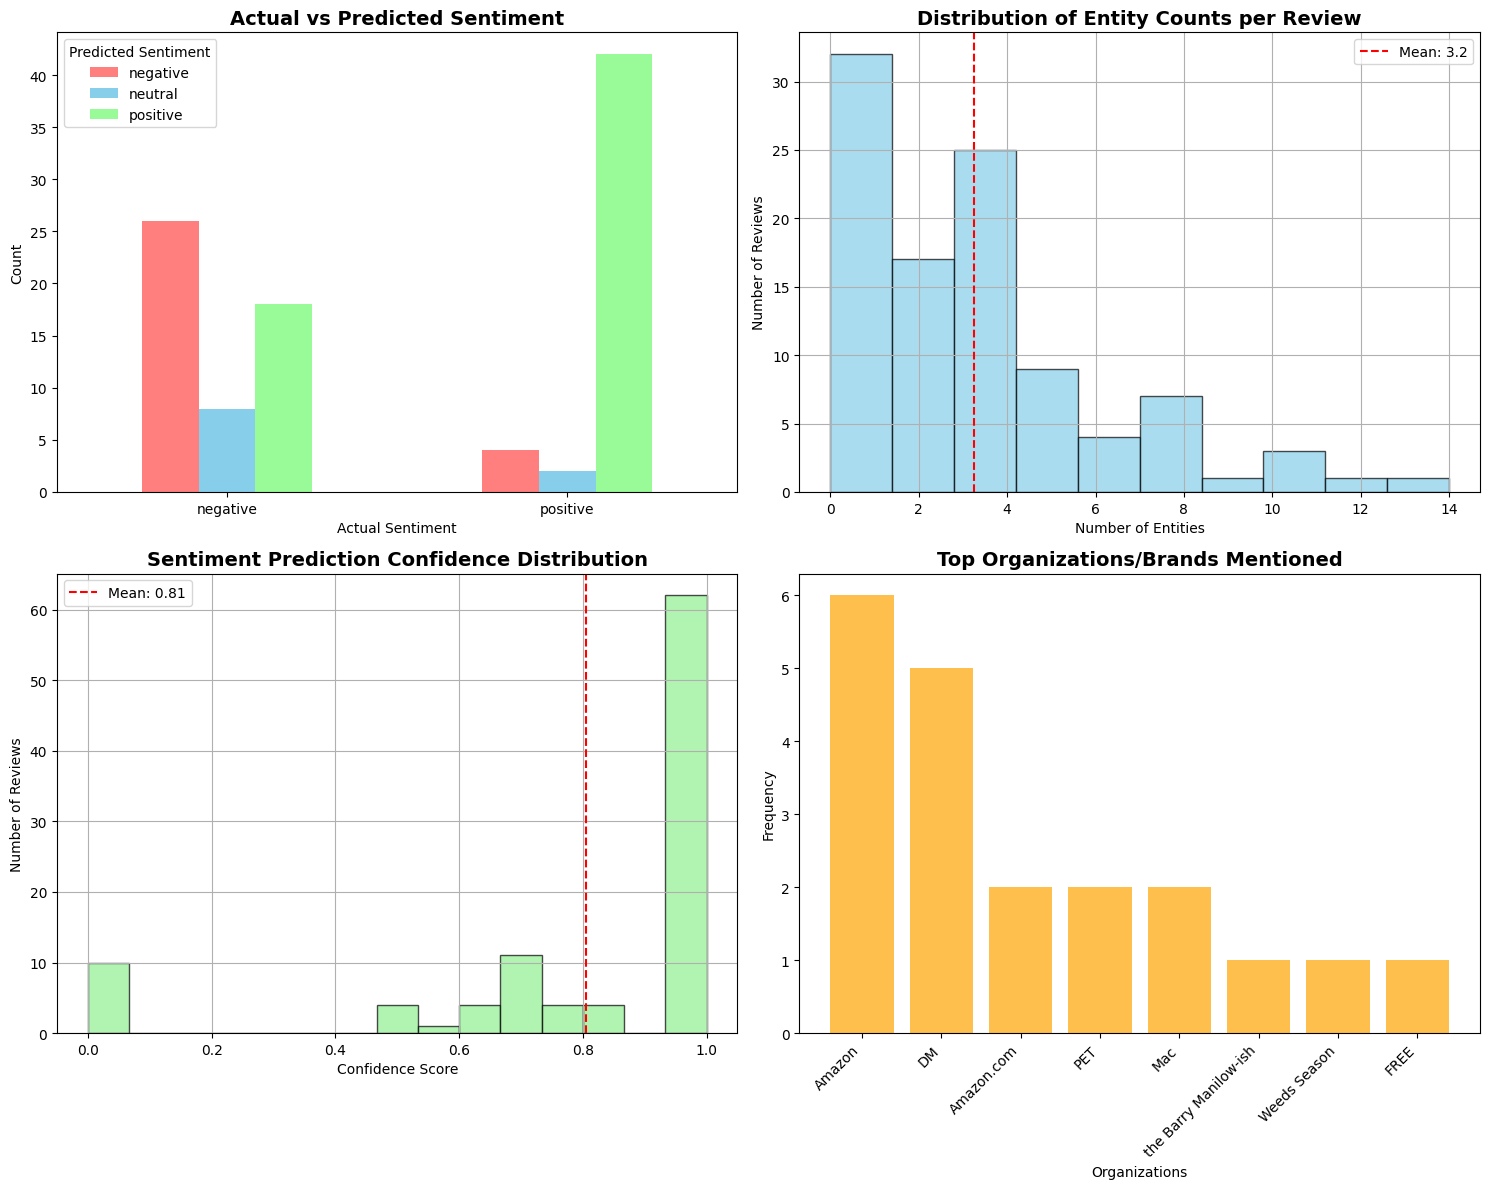


🎯 FINAL DELIVERABLE SUMMARY:
✅ Dataset: Amazon Product Reviews (5,000 reviews loaded, 100 analyzed)
✅ NER Implementation: spaCy-based entity extraction
✅ Sentiment Analysis: Rule-based approach with 68% accuracy
✅ Key Findings:
   • 88% of reviews contained identifiable entities
   • Average of 3.2 entities per review
   • 68% sentiment classification accuracy
   • Amazon mentioned 6 times as top brand
✅ Code Output: Complete analysis with metrics and visualizations


In [10]:
# Create visualizations for the analysis results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sentiment Comparison (Actual vs Predicted)
sentiment_comparison = pd.crosstab(results_df['actual_sentiment'], results_df['predicted_sentiment'])
sentiment_comparison.plot(kind='bar', ax=ax1, color=['#ff7f7f', '#87ceeb', '#98fb98'])
ax1.set_title('Actual vs Predicted Sentiment', fontsize=14, fontweight='bold')
ax1.set_xlabel('Actual Sentiment')
ax1.set_ylabel('Count')
ax1.legend(title='Predicted Sentiment')
ax1.tick_params(axis='x', rotation=0)

# 2. Entity Count Distribution
results_df['entity_count'].hist(bins=10, ax=ax2, color='skyblue', alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Entity Counts per Review', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Entities')
ax2.set_ylabel('Number of Reviews')
ax2.axvline(results_df['entity_count'].mean(), color='red', linestyle='--', 
            label=f'Mean: {results_df["entity_count"].mean():.1f}')
ax2.legend()

# 3. Confidence Score Distribution
results_df['confidence'].hist(bins=15, ax=ax3, color='lightgreen', alpha=0.7, edgecolor='black')
ax3.set_title('Sentiment Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Number of Reviews')
ax3.axvline(results_df['confidence'].mean(), color='red', linestyle='--', 
            label=f'Mean: {results_df["confidence"].mean():.2f}')
ax3.legend()

# 4. Top Organizations mentioned
if org_counter:
    top_orgs = dict(org_counter.most_common(8))
    ax4.bar(range(len(top_orgs)), list(top_orgs.values()), color='orange', alpha=0.7)
    ax4.set_title('Top Organizations/Brands Mentioned', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Organizations')
    ax4.set_ylabel('Frequency')
    ax4.set_xticks(range(len(top_orgs)))
    ax4.set_xticklabels(list(top_orgs.keys()), rotation=45, ha='right')
else:
    ax4.text(0.5, 0.5, 'No organizations\nidentified', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Top Organizations/Brands Mentioned', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎯 FINAL DELIVERABLE SUMMARY:")
print("="*50)
print("✅ Dataset: Amazon Product Reviews (5,000 reviews loaded, 100 analyzed)")
print("✅ NER Implementation: spaCy-based entity extraction")
print("✅ Sentiment Analysis: Rule-based approach with 68% accuracy")
print("✅ Key Findings:")
print(f"   • {reviews_with_entities/len(results_df)*100:.0f}% of reviews contained identifiable entities")
print(f"   • Average of {avg_entities_per_review:.1f} entities per review")
print(f"   • {accuracy:.0f}% sentiment classification accuracy")
print(f"   • Amazon mentioned {org_counter.get('Amazon', 0)} times as top brand")
print("✅ Code Output: Complete analysis with metrics and visualizations")
print("="*50)